# Architectures

The aim of this notebook is to test different encoder-decoder combinations.Based on the earlier results, we limited the decoders to two most successful ones:

- [Unet++](https://arxiv.org/pdf/1807.10165.pdf)
- [DeepLabV3](https://arxiv.org/abs/1706.05587)

These will now be combined with different encoders:
- [ResNet](https://arxiv.org/abs/1512.03385)
- [ResNeXt](https://arxiv.org/abs/1611.05431)
- [VGG](https://arxiv.org/abs/1409.1556)
- [EfficientNet](https://arxiv.org/abs/1905.11946)
- [Inception](https://arxiv.org/abs/1409.4842)

## Google Colab

The first cell will only be run in Google Colab, the second one locally as well.

In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
import os
import glob

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str: 
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive = True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('architectures.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

## Imports

In [18]:
import os
import cv2
import torch

import albumentations as A
import pandas as pd
import segmentation_models_pytorch as smp

from matplotlib import colors
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from distutils.spawn import find_executable
from scripts.evaluation import EvaluationMonitor, get_best_f1_per_setup
from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model, setup_seed
from scripts.plotting import plot_post_processing
from torch.utils.data import DataLoader, SubsetRandomSampler

In [4]:
# necessary for downloading some of the models
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
setup_seed(16)

## Data

In [6]:
# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

In [7]:
# image paths so that all the images are used for train dataset (no test set for cv due to small training set)
image_path_train, _, mask_path_train, _ = split_data(train_directory, test_size=0)

# create train Dataset without transformations for now
train_dataset = RoadDataset(image_path_train, mask_path_train)

In [8]:
# define transformations
train_tf = A.Compose([
    A.Resize(height=608, width=608, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomSnow(p=0.1)
])

valid_tf = A.Compose([A.Resize(height=608, width=608, always_apply=True)])

## Encode-Decoder Combinations



In [9]:
# specify the root path for evaluation json-s
evaluation_dir = os.path.join(ROOT_PATH, 'data', 'results', 'architectures')
monitor = EvaluationMonitor(evaluation_dir)
ENC_DEC_COMBINATIONS = monitor.get_not_updated_models()

## Hyperparameters

Since our aim is to see, how different architectures influence the training, we fix the model, epochs and batch sizes.

In [10]:
ENCODER_WEIGHTS = 'imagenet'

SEED = 16
BATCH_SIZE = 4
K_FOLD = 3
N_CPU = os.cpu_count()
N_EPOCHS = 150

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE,
    'num_workers': N_CPU,
    'persistent_workers': True
}

## Cross-Validation

In [11]:
for encoder, decoder in ENC_DEC_COMBINATIONS:

    print(f'encoder-decoder: {encoder}-{decoder}')

    k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=SEED)

    # Record K-fold results in a (K_FOLD, num_epoch) matrix
    training_loss_matrix = []
    validation_loss_matrix = []
    training_f1_matrix = []
    validation_f1_matrix = []

    # Get training and validation indices
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):

        print(f'fold: {fold}')

        # Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
        train_loader = DataLoader(train_dataset.set_tf(train_tf), sampler=SubsetRandomSampler(train_idx), **LOADER_PARAMS)
        valid_loader = DataLoader(train_dataset.set_tf(valid_tf), sampler=SubsetRandomSampler(val_idx), **LOADER_PARAMS)

        # Initialize model
        model_ = smp.create_model(decoder, encoder_name=encoder, encoder_weights=ENCODER_WEIGHTS)
        criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
        scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer_,
            T_max=(len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size,
        )

        # Train model
        train_losses, valid_losses, train_f1s, valid_f1s = train_model(
            model_, (train_loader, valid_loader), criterion_, optimizer_, scheduler_, N_EPOCHS
        )

        # Save epoch results
        training_loss_matrix.append(train_f1s)
        validation_loss_matrix.append(train_f1s)
        training_f1_matrix.append(train_f1s)
        validation_f1_matrix.append(valid_f1s)
    
    monitor.update_metrics(
        (encoder, decoder),
        training_f1=training_f1_matrix,
        training_loss=training_loss_matrix,
        validation_f1=validation_f1_matrix,
        validation_loss=validation_loss_matrix
    )
    monitor.update_jsons()

## Metrics

CV was run on colab, the results saved to JSON, and now we can start analysing them.

In [12]:
stats_df = get_best_f1_per_setup(monitor.metrics['validation_f1'])
stats_df

,top_f1,std_dev
"(resnet101, UnetPlusPlus)",0.851941,0.005886
"(resnet101, DeepLabV3)",0.852060,0.020864
"(vgg19, UnetPlusPlus)",0.837727,0.018677
"(inceptionv4, UnetPlusPlus)",0.865252,0.013816
"(mit_b2, Unet)",0.853988,0.012551
"(resnext50_32x4d, DeepLabV3)",0.857251,0.018591
"(efficientnet-b4, UnetPlusPlus)",0.858830,0.012563


In [13]:
# let's split the encoder and decoder for better formatting
stats_df.reset_index(inplace=True, names=['enc_dec'])
stats_df[['encoder', 'decoder']] = pd.DataFrame(stats_df['enc_dec'].tolist(), index=stats_df.index)
stats_df.drop(columns='enc_dec', inplace=True)
stats_df.replace("UnetPlusPlus","Unet++", inplace=True)

# remove resnet101-Unet++ as the mean performance is almost identical to resnet101-DeepLabV3
stats_df.drop([1], inplace=True)
stats_df

,top_f1,std_dev,encoder,decoder
0,0.851941,0.005886,resnet101,Unet++
2,0.837727,0.018677,vgg19,Unet++
3,0.865252,0.013816,inceptionv4,Unet++
4,0.853988,0.012551,mit_b2,Unet
5,0.857251,0.018591,resnext50_32x4d,DeepLabV3
6,0.858830,0.012563,efficientnet-b4,Unet++


In [14]:
# specify the parameter count for encoders
parameter_count = {
    'resnet101': 42,
    'resnext50_32x4d': 22,
    'vgg19': 20,
    'efficientnet-b4': 17,
    'inceptionv4': 41,
    'mit_b2': 24
}

# add parameters to df
stats_df['parameter_count'] = stats_df.encoder.apply(lambda x: parameter_count[x])

In [15]:
# specify the annotation setup (final name, shift-x, shift-y)
annotation_config = {
    'resnet101-Unet++': ('ResNet-Unet++', -12, -0.013),
    'vgg19-Unet++': ('VGG-Unet++', 4, -0.01),
    'inceptionv4-Unet++': ('Inception-Unet++', -12, 0.005),
    'mit_b2-Unet': ('SegFormer-Unet', 2, 0),
    'resnext50_32x4d-DeepLabV3': ('ResNeXt-DeepLabV3', 3, 0.005),
    'efficientnet-b4-Unet++': ('EfficientNet-Unet++', 6.5, 0.018),
}

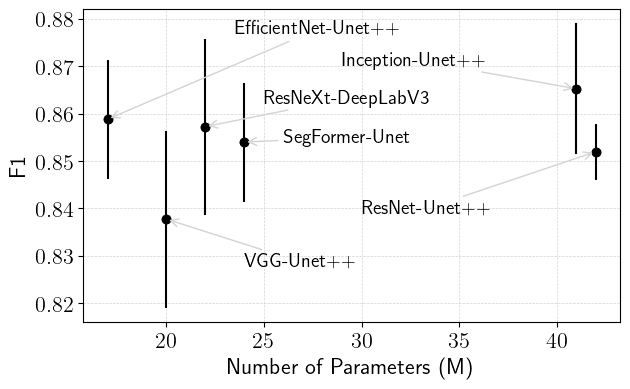

In [20]:
# plot the results
fig, ax = plt.subplots(figsize=(6.4, 4.))

plt.rc('text', usetex=bool(find_executable('latex')))

x = stats_df.parameter_count
y = stats_df.top_f1

for i, row in stats_df.iterrows():
    # get annotation params
    raw_name = '-'.join([row.encoder, row.decoder])
    name, x_text, y_text = annotation_config[raw_name]
    
    # specify x and y
    x = row.parameter_count
    y = row.top_f1
    
    # plot the data with errorbars and annotations
    error = row.std_dev
    plt.scatter(x, y, alpha=0.7, color='black')
    plt.errorbar(x, y, yerr=error, fmt="o", color='black')
    ax.annotate(name, xy=(x, y), xytext=(x + x_text, y + y_text), arrowprops=dict(arrowstyle="->", color=colors.to_rgba('lightgrey')), fontsize=14)

plot_post_processing(y_label=r'$F1$', x_label=r'$Number of Parameters (M)$', legend=False)